In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import folktables
from folktables import ACSDataSource, ACSEmployment, generate_categories, ACSIncome, ACSHealthInsurance
import matplotlib
matplotlib.use("agg")
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.graphics.regressionplots import abline_plot
from statsmodels.formula.api import ols
from scipy.stats import linregress
import math
import sklearn
from sklearn.metrics import mean_squared_error
import statistics
import numpy as np
import seaborn as sns

In [2]:
ACSIncome_categories = {
    "COW": {
        1.0: (
            "Employee of a private for-profit company or"
            "business, or of an individual, for wages,"
            "salary, or commissions"
        ),
        2.0: (
            "Employee of a private not-for-profit, tax-exempt,"
            "or charitable organization"
        ), 
        3.0: "Local government employee (city, county, etc.)",
        4.0: "State government employee",
        5.0: "Federal government employee", 
        6.0: (
            "Self-employed in own not incorporated business,"
            "professional practice, or farm"
        ),
        7.0: (
            "Self-employed in own incorporated business,"
            "professional practice or farm"
        ),
        8.0: "Working without pay in family business or farm",
        9.0: "Unemployed and last worked 5 years ago or earlier or never worked",
    },
    "SCHL": {
        1.0: "No schooling completed",
        2.0: "Nursery school, preschool",
        3.0: "Kindergarten",
        4.0: "Grade 1",
        5.0: "Grade 2",
        6.0: "Grade 3",
        7.0: "Grade 4",
        8.0: "Grade 5",
        9.0: "Grade 6",
        10.0: "Grade 7",
        11.0: "Grade 8",
        12.0: "Grade 9",
        13.0: "Grade 10",
        14.0: "Grade 11",
        15.0: "12th grade - no diploma",
        16.0: "Regular high school diploma",
        17.0: "GED or alternative credential",
        18.0: "Some college, but less than 1 year",
        19.0: "1 or more years of college credit, no degree",
        20.0: "Associate's degree",
        21.0: "Bachelor's degree",
        22.0: "Master's degree",
        23.0: "Professional degree beyond a bachelor's degree",
        24.0: "Doctorate degree",
    },
    "MAR": {
        1.0: "Married",
        2.0: "Widowed",
        3.0: "Divorced",
        4.0: "Separated",
        5.0: "Never married or under 15 years old",
    },
    "SEX": {1.0: "Male", 2.0: "Female"},
    "RAC1P": {
        1.0: "White alone",
        2.0: "Black or African American alone",
        3.0: "American Indian alone",
        4.0: "Alaska Native alone",
        5.0: (
            "American Indian and Alaska Native tribes specified;"
            "or American Indian or Alaska Native,"
            "not specified and no other"
        ),
        6.0: "Asian alone",
        7.0: "Native Hawaiian and Other Pacific Islander alone",
        8.0: "Some Other Race alone",
        9.0: "Two or More Races",
    },
}

## Plotting

In [3]:
#edited to include WAGP
ACSIncome = folktables.BasicProblem(
    features=[
        'AGEP',
        'COW',
        'SCHL',
        'MAR',
        'OCCP',
        'POBP',
        'RELP',
        'WKHP',
        'SEX',
        'RAC1P',
        'WAGP'
    ],
    target='PINCP',
    target_transform=lambda x: x > 50000,    
    group='RAC1P',
    preprocess=folktables.adult_filter,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

In [4]:
data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
ca_data = data_source.get_data(states=["CA"], download=True)

ca_features1, ca_labels1, _ = ACSIncome.df_to_pandas(ca_data, categories=ACSIncome_categories, dummies=False)
ca_features1.head()

,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,RAC1P,WAGP
0,30,Self-employed in own not incorporated business...,Grade 11,Married,9610.0,6,16,40.0,Male,Some Other Race alone,500.0
1,21,State government employee,Regular high school diploma,Never married or under 15 years old,1970.0,6,17,20.0,Male,White alone,7700.0
2,65,"Employee of a private not-for-profit, tax-exem...",Master's degree,Never married or under 15 years old,2040.0,6,17,8.0,Male,White alone,5000.0
3,33,Employee of a private for-profit company orbus...,Grade 11,Divorced,9610.0,36,16,40.0,Male,White alone,12000.0
4,18,"Employee of a private not-for-profit, tax-exem...","1 or more years of college credit, no degree",Never married or under 15 years old,1021.0,6,17,18.0,Female,White alone,300.0


In [5]:
ca_features1

,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,RAC1P,WAGP
0,30,Self-employed in own not incorporated business...,Grade 11,Married,9610.0,6,16,40.0,Male,Some Other Race alone,500.0
1,21,State government employee,Regular high school diploma,Never married or under 15 years old,1970.0,6,17,20.0,Male,White alone,7700.0
2,65,"Employee of a private not-for-profit, tax-exem...",Master's degree,Never married or under 15 years old,2040.0,6,17,8.0,Male,White alone,5000.0
3,33,Employee of a private for-profit company orbus...,Grade 11,Divorced,9610.0,36,16,40.0,Male,White alone,12000.0
4,18,"Employee of a private not-for-profit, tax-exem...","1 or more years of college credit, no degree",Never married or under 15 years old,1021.0,6,17,18.0,Female,White alone,300.0
...,...,...,...,...,...,...,...,...,...,...,...
195660,38,Employee of a private for-profit company orbus...,Master's degree,Married,1021.0,210,0,40.0,Male,Asian alone,565000.0
195661,39,Employee of a private for-profit company orbus...,Master's degree,Married,1021.0,210,1,40.0,Female,Asian alone,209000.0
195662,61,Employee of a private for-profit company orbus...,"1 or more years of college credit, no degree",Married,5240.0,17,0,45.0,Male,White alone,105000.0
195663,69,"Self-employed in own incorporated business,pro...",Doctorate degree,Married,2040.0,207,0,45.0,Male,Asian alone,30000.0


In [6]:
asian=ca_features1[ca_features1['RAC1P']=='Asian alone']
black=ca_features1[ca_features1['RAC1P']=='Black or African American alone']
white=ca_features1[ca_features1['RAC1P']=='White alone']
hisp=ca_features1[ca_features1['RAC1P']=='Some Other Race alone']
plottable=pd.concat([asian, black, white, hisp])
#plottable=plottable.drop(["Alaska Native alone","American Indian and Alaska Native tribes specified;or American Indian or Alaska Native,not specified and no other", "Some Other Race alone", "White alone", "Two or More Races", "Black or African American alone", "American Indian alone", "Native Hawaiian and Other Pacific Islander alone", "Asian alone"], axis=1)
plottable['AGEP'] = plottable['AGEP'].astype(int) #changing strings with numbers to integers
plottable['OCCP'] = plottable['OCCP'].astype(int)
plottable['POBP'] = plottable['POBP'].astype(int)
plottable['RELP'] = plottable['RELP'].astype(int)
plottable['WKHP'] = plottable['WKHP'].astype(int)
plottable['WAGP'] = plottable['WAGP'].astype(int)
plottable


,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,RAC1P,WAGP
27,23,"Employee of a private not-for-profit, tax-exem...",Bachelor's degree,Never married or under 15 years old,2545,207,17,20,Female,Asian alone,4000
33,18,Employee of a private for-profit company orbus...,Regular high school diploma,Never married or under 15 years old,9610,6,17,8,Female,Asian alone,1500
49,18,Employee of a private for-profit company orbus...,"Some college, but less than 1 year",Never married or under 15 years old,725,6,17,12,Female,Asian alone,1400
53,25,State government employee,Bachelor's degree,Never married or under 15 years old,3870,6,17,40,Male,Asian alone,13000
80,20,"Employee of a private not-for-profit, tax-exem...",GED or alternative credential,Never married or under 15 years old,725,6,17,18,Female,Asian alone,650
...,...,...,...,...,...,...,...,...,...,...,...
195602,24,Employee of a private for-profit company orbus...,Bachelor's degree,Never married or under 15 years old,2300,6,2,40,Female,Some Other Race alone,20000
195628,46,Employee of a private for-profit company orbus...,GED or alternative credential,Married,8740,303,0,40,Female,Some Other Race alone,12000
195629,50,Employee of a private for-profit company orbus...,12th grade - no diploma,Married,7340,303,1,50,Male,Some Other Race alone,17900
195642,42,Employee of a private for-profit company orbus...,Grade 9,Married,6260,303,0,40,Male,Some Other Race alone,61000


In [7]:
X_plot=plottable.sample(n=1000)

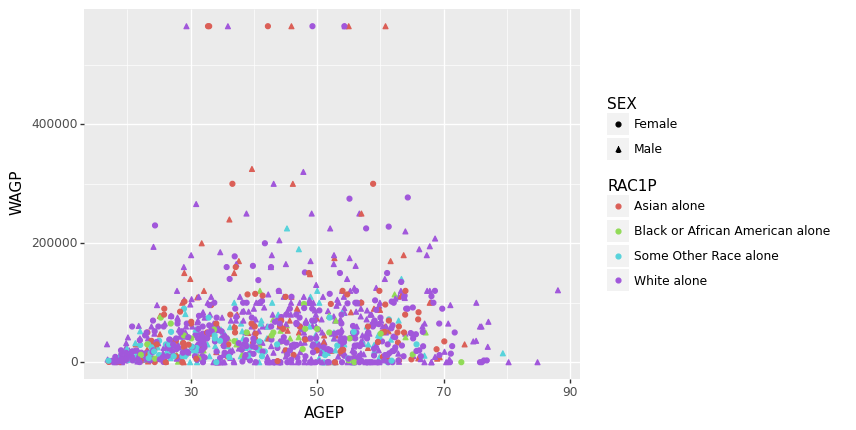

<ggplot: (130774611398)>

In [8]:
import  plotnine
from plotnine import ggplot, aes, geom_line, geom_jitter

(
    ggplot(X_plot)  # What data to use
    + aes(x="AGEP", y="WAGP", color="RAC1P")  # What variable to use
    + geom_jitter(aes(shape='SEX'))  # Geometric object to use for drawing
)

In [9]:
#average income by race and gender
by_race_gender_mean = plottable.groupby(['RAC1P','SEX'],as_index=False).WAGP.mean()
by_race_gender_median = plottable.groupby(['RAC1P','SEX'],as_index=False).WAGP.median()
print(by_race_gender_mean,"\n")
print(by_race_gender_median)

                             RAC1P     SEX          WAGP
0                      Asian alone  Female  56007.046421
1                      Asian alone    Male  77033.169036
2  Black or African American alone  Female  42379.526763
3  Black or African American alone    Male  47982.783064
4            Some Other Race alone  Female  27349.548635
5            Some Other Race alone    Male  36154.811007
6                      White alone  Female  46741.492182
7                      White alone    Male  69619.722964 

                             RAC1P     SEX     WAGP
0                      Asian alone  Female  40000.0
1                      Asian alone    Male  50000.0
2  Black or African American alone  Female  30000.0
3  Black or African American alone    Male  32000.0
4            Some Other Race alone  Female  21500.0
5            Some Other Race alone    Male  30000.0
6                      White alone  Female  30000.0
7                      White alone    Male  43000.0


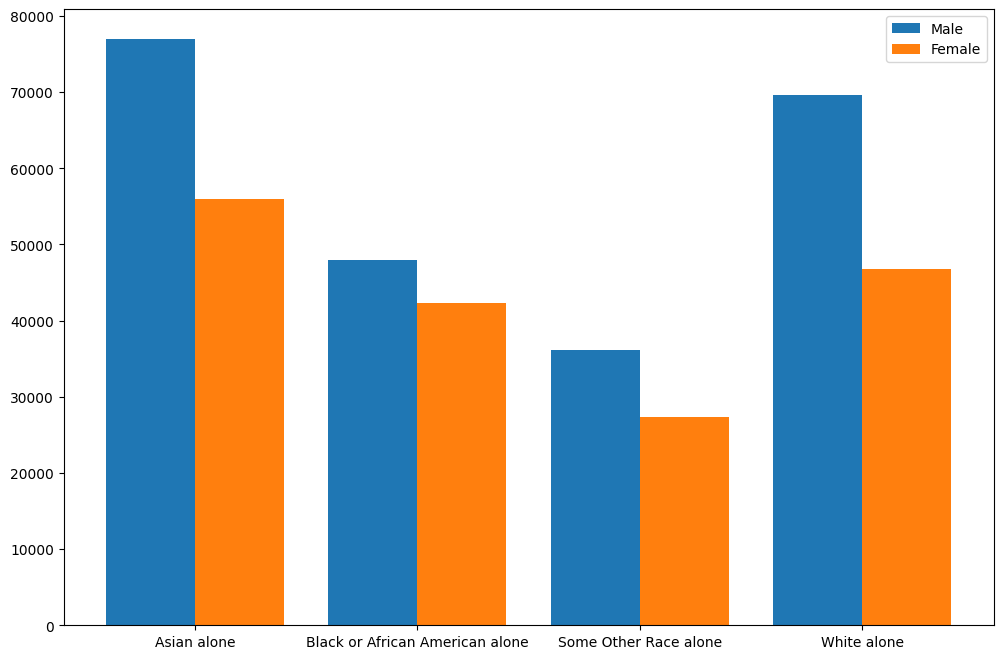

In [10]:
fig, ax = plt.subplots(figsize=(12, 8))
x = np.arange(len(by_race_gender_mean.RAC1P.unique()))

# Define bar width. We'll use this to offset the second bar.
bar_width = 0.4

# Note we add the `width` parameter now which sets the width of each bar.
b1 = ax.bar(x, by_race_gender_mean.loc[by_race_gender_mean['SEX'] == 'Male', 'WAGP'],
            width=bar_width, label='Male')
# Same thing, but offset the x by the width of the bar.
b2 = ax.bar(x + bar_width, by_race_gender_mean.loc[by_race_gender_mean['SEX'] == 'Female', 'WAGP'],
            width=bar_width, label="Female")
# Fix the x-axes.
ax.set_xticks(x + bar_width / 2)
ax.set_xticklabels(by_race_gender_mean.RAC1P.unique())

ax.legend()

In [11]:
by_race_gender_mar = plottable.groupby(['RAC1P','SEX','MAR'],as_index=False).WAGP.mean()
print(by_race_gender_mar)

                              RAC1P     SEX  \
0                       Asian alone  Female   
1                       Asian alone  Female   
2                       Asian alone  Female   
3                       Asian alone  Female   
4                       Asian alone  Female   
5                       Asian alone    Male   
6                       Asian alone    Male   
7                       Asian alone    Male   
8                       Asian alone    Male   
9                       Asian alone    Male   
10  Black or African American alone  Female   
11  Black or African American alone  Female   
12  Black or African American alone  Female   
13  Black or African American alone  Female   
14  Black or African American alone  Female   
15  Black or African American alone    Male   
16  Black or African American alone    Male   
17  Black or African American alone    Male   
18  Black or African American alone    Male   
19  Black or African American alone    Male   
20           

In [12]:
plottable['RAC1P'].value_counts()

White alone                        121006
Asian alone                         32709
Some Other Race alone               22793
Black or African American alone      8557
Name: RAC1P, dtype: int64

In [13]:
plottable.describe()

,AGEP,OCCP,POBP,RELP,WKHP,WAGP
count,185065.000000,185065.000000,185065.000000,185065.000000,185065.000000,185065.000000
mean,42.993132,4011.509697,95.723724,2.475671,37.923811,56374.287521
std,14.878392,2640.292567,123.314537,4.409421,12.974830,76294.262941
min,17.000000,10.000000,1.000000,0.000000,1.000000,0.000000
25%,30.000000,2014.000000,6.000000,0.000000,32.000000,13000.000000
50%,43.000000,4055.000000,12.000000,1.000000,40.000000,35000.000000
75%,55.000000,5522.000000,213.000000,2.000000,40.000000,72000.000000
max,94.000000,9830.000000,554.000000,17.000000,99.000000,565000.000000


Text(0.5, 1.0, 'Distribution of Gender')

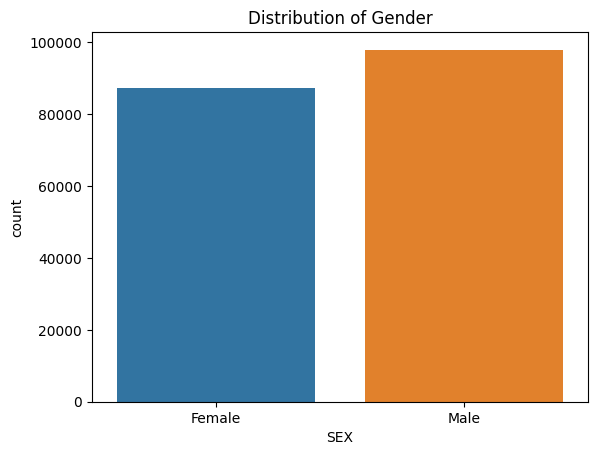

In [14]:
sns.countplot(x='SEX', data=plottable)
plt.title('Distribution of Gender')

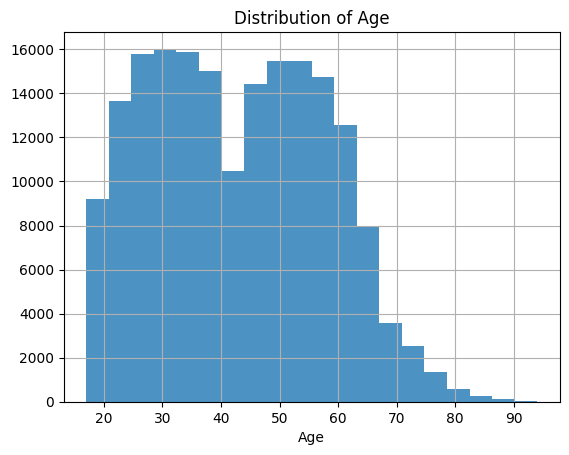

In [15]:
plt.grid()
plt.hist(plottable['AGEP'], bins=20, alpha=0.8)
plt.title('Distribution of Age');
plt.xlabel('Age');

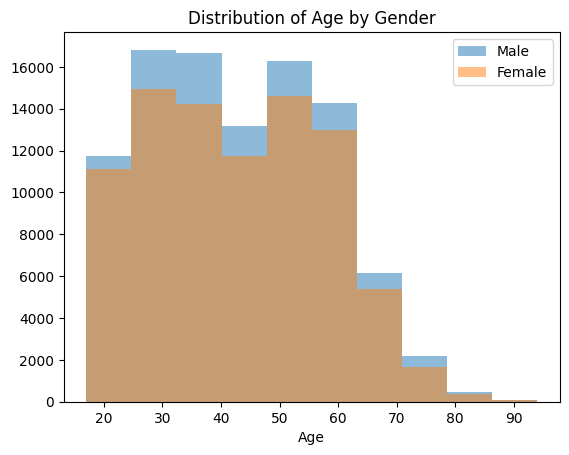

In [16]:
plt.hist('AGEP', data=plottable[plottable['SEX'] == 'Male'], alpha=0.5, label='Male')
plt.hist('AGEP', data=plottable[plottable['SEX'] == 'Female'], alpha=0.5, label='Female')
plt.title('Distribution of Age by Gender')
plt.xlabel('Age')
plt.legend()

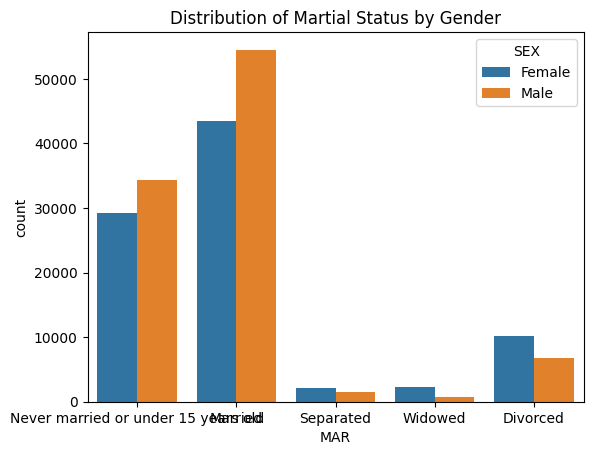

In [17]:
sns.countplot(x="MAR", hue="SEX", data=plottable);
plt.title('Distribution of Martial Status by Gender');

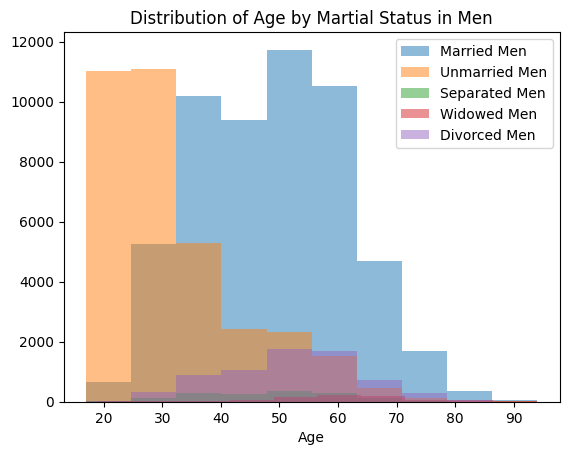

In [18]:
married_men = plottable[(plottable['MAR'] == 'Married') & (plottable['SEX'] == 'Male')]
unmarried_men = plottable[(plottable['MAR'] == 'Never married or under 15 years old') & (plottable['SEX'] == 'Male')]
separated_men = plottable[(plottable['MAR'] == 'Separated') & (plottable['SEX'] == 'Male')]
widowed_men = plottable[(plottable['MAR'] == 'Widowed') & (plottable['SEX'] == 'Male')]
divorced_men = plottable[(plottable['MAR'] == 'Divorced') & (plottable['SEX'] == 'Male')]

plt.hist('AGEP', data= married_men , alpha=0.5, label='Married Men')
plt.hist('AGEP', data= unmarried_men , alpha=0.5, label='Unmarried Men')
plt.hist('AGEP', data= separated_men , alpha=0.5, label='Separated Men')
plt.hist('AGEP', data= widowed_men , alpha=0.5, label='Widowed Men')
plt.hist('AGEP', data= divorced_men , alpha=0.5, label='Divorced Men')

plt.title('Distribution of Age by Martial Status in Men')

plt.xlabel('Age');
plt.legend();

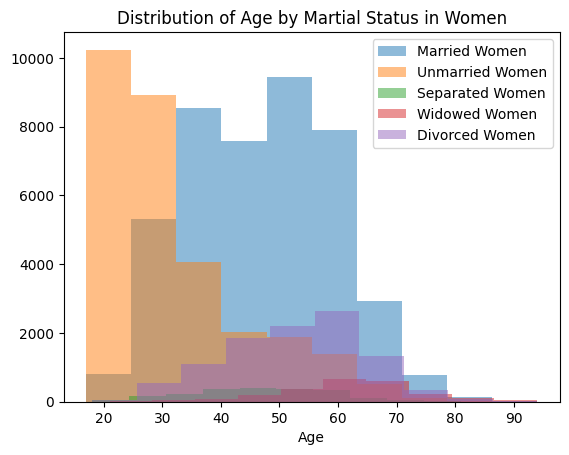

In [19]:
married_women = plottable[(plottable['MAR'] == 'Married') & (plottable['SEX'] == 'Female')]
unmarried_women = plottable[(plottable['MAR'] == 'Never married or under 15 years old') & (plottable['SEX'] == 'Female')]
separated_women = plottable[(plottable['MAR'] == 'Separated') & (plottable['SEX'] == 'Female')]
widowed_women = plottable[(plottable['MAR'] == 'Widowed') & (plottable['SEX'] == 'Female')]
divorced_women = plottable[(plottable['MAR'] == 'Divorced') & (plottable['SEX'] == 'Female')]

plt.hist('AGEP', data= married_women , alpha=0.5, label='Married Women')
plt.hist('AGEP', data= unmarried_women , alpha=0.5, label='Unmarried Women')
plt.hist('AGEP', data= separated_women , alpha=0.5, label='Separated Women')
plt.hist('AGEP', data= widowed_women , alpha=0.5, label='Widowed Women')
plt.hist('AGEP', data= divorced_women , alpha=0.5, label='Divorced Women')

plt.title('Distribution of Age by Martial Status in Women')

plt.xlabel('Age');
plt.legend();